# Estudo de Churn Rate

   ## O que é churn rate?

Churn rate, também conhecida como índice de cancelamento, é uma métrica estatística utilizada para medir a proporção de indivíduos ou itens que saem de algum grupo.
É a principal métrica para identificar a quantidade de clientes que deixam um negócio. Muito comum em serviços de assinatura e pagamentos recorrentes.

Para uma expansão bem-sucedida de uma empresa, é essencial que o número de novos clientes supere o número de cancelamentos.

Um churn alto pode indicar vendas ineficazes, onde clientes com baixa aderência ao produto cancelam pouco tempo após a compra.

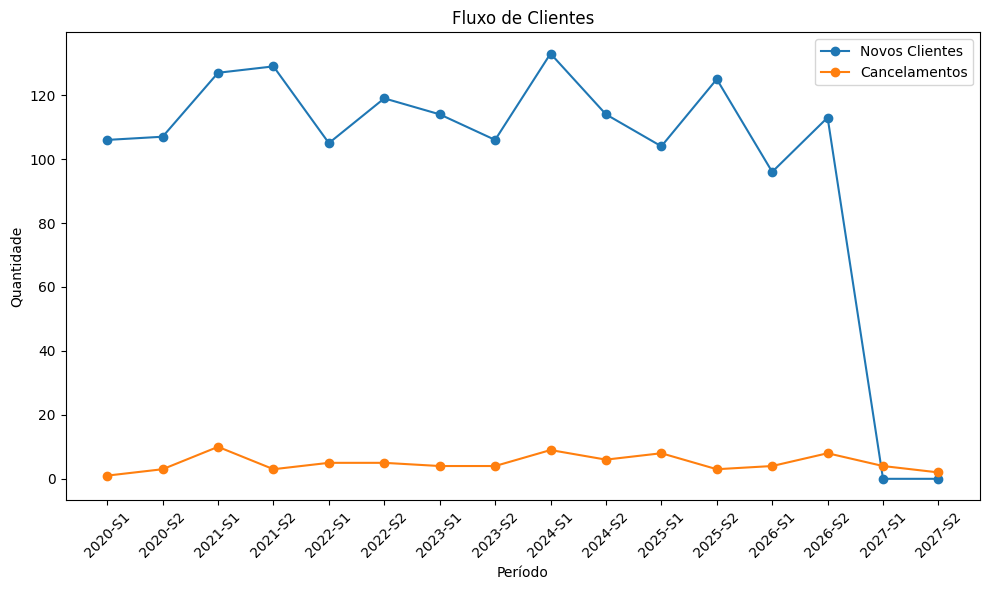

Tabela final com churn por semestre:


,periodo,Novos clientes,cancelamentos,clientes_ativos,ativos_anteriores,base_churn,churn (%)
0,2020-S1,106,1,105,0.0,106.0,0.94
1,2020-S2,107,3,209,105.0,212.0,1.42
2,2021-S1,127,10,326,209.0,336.0,2.98
3,2021-S2,129,3,452,326.0,455.0,0.66
4,2022-S1,105,5,552,452.0,557.0,0.90
5,2022-S2,119,5,666,552.0,671.0,0.75
6,2023-S1,114,4,776,666.0,780.0,0.51
7,2023-S2,106,4,878,776.0,882.0,0.45
8,2024-S1,133,9,1002,878.0,1011.0,0.89
9,2024-S2,114,6,1110,1002.0,1116.0,0.54


In [1]:
# Calculo da taxa de Churn:
# Churn (%) = (Cancelamentos / (Clientes do período anterior + Novos Clientes)) * 100

# Imports
import pandas as pd
import numpy as np
import names
import random
from datetime import timedelta
import matplotlib.pyplot as plt

# Geração da base sintética
tamanho_base = 1598
percentual_cancelamento = np.random.choice([3, 5, 8, 10, 12, 16, 22])

def criar_base(tamanho_base):
    cancelamentos = int(tamanho_base * percentual_cancelamento / 100)

    df = pd.DataFrame({
        'clientes': [names.get_full_name() for _ in range(tamanho_base)],
        'data_aquisicao': np.random.choice(pd.date_range('2020-01-01', '2026-12-31'), tamanho_base),
        'dat_cancelamento': pd.to_datetime([
            f"{np.random.randint(1, 13)}/{np.random.randint(1, 29)}/{np.random.randint(2010, 2023)}"
            if i < cancelamentos else None
            for i in range(tamanho_base)
        ])
    })

    df['dat_cancelamento'] = df.apply(
        lambda row: row['data_aquisicao'] + timedelta(days=random.randint(30, 365))
        if pd.notnull(row['dat_cancelamento']) else None,
        axis=1
    )
    return df

df = criar_base(tamanho_base)
df.to_csv("clientes.csv", index=False)
df = pd.read_csv("clientes.csv", parse_dates=['data_aquisicao', 'dat_cancelamento'])

# Tratamento por semestre
df_aquisicoes = df.groupby("data_aquisicao").size().reset_index(name="Novos clientes")
df_aquisicoes["data_aquisicao"] = df_aquisicoes["data_aquisicao"].dt.year.astype(str) + "-S" + \
    ((df_aquisicoes["data_aquisicao"].dt.month - 1) // 6 + 1).astype(str)
df_aquisicoes = df_aquisicoes.groupby("data_aquisicao").sum().reset_index()

df_cancelados = df.groupby("dat_cancelamento").size().reset_index(name="cancelamentos")
df_cancelados["dat_cancelamento"] = df_cancelados["dat_cancelamento"].apply(
    lambda x: f"{x.year}-S{(x.month - 1)//6 + 1}" if pd.notnull(x) else None
)
df_cancelados = df_cancelados.groupby("dat_cancelamento").sum().reset_index()

# Geração dos periodos
ano_inicio = df["data_aquisicao"].min().year
ano_fim = df["dat_cancelamento"].max().year
anos = range(ano_inicio, ano_fim + 1)
semestres = ["S1", "S2"]
todos_periodos = [f"{ano}-{sem}" for ano in anos for sem in semestres]
df_periodo_total = pd.DataFrame({"periodo": todos_periodos})

# Junção das bases

df_periodo = df_periodo_total.merge(df_aquisicoes, left_on="periodo", right_on="data_aquisicao", how="left")
df_periodo = df_periodo.merge(df_cancelados, left_on="periodo", right_on="dat_cancelamento", how="left")
df_periodo = df_periodo[["periodo", "Novos clientes", "cancelamentos"]].fillna(0)

# Cálculo do churn

df_periodo["Novos clientes"] = df_periodo["Novos clientes"].astype(int)
df_periodo["cancelamentos"] = df_periodo["cancelamentos"].astype(int)
df_periodo["clientes_ativos"] = df_periodo["Novos clientes"].cumsum() - df_periodo["cancelamentos"].cumsum()
df_periodo["ativos_anteriores"] = df_periodo["clientes_ativos"].shift(1).fillna(0)
df_periodo["base_churn"] = df_periodo["ativos_anteriores"] + df_periodo["Novos clientes"]
df_periodo["churn (%)"] = (df_periodo["cancelamentos"] / df_periodo["base_churn"].replace(0, 1)) * 100
df_periodo["churn (%)"] = df_periodo["churn (%)"].round(2)

# Visualização
plt.figure(figsize=(10,6))
plt.plot(df_periodo["periodo"], df_periodo["Novos clientes"], marker='o', label="Novos Clientes")
plt.plot(df_periodo["periodo"], df_periodo["cancelamentos"], marker='o', label="Cancelamentos")
plt.xticks(rotation=45)
plt.xlabel("Período")
plt.ylabel("Quantidade")
plt.title("Fluxo de Clientes")
plt.legend()
plt.tight_layout()
plt.show()

print("Tabela final com churn por semestre:")
display(df_periodo)
